In [1]:
from __future__ import print_function
import os
import numpy as np
import keras

import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

np.random.seed(1337)

from binary_ops import binary_tanh as binary_tanh_op
from binary_layers import BinaryDense, Clip

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
from keras.preprocessing import image

In [3]:
class DropoutNoScale(Dropout):
    '''Keras Dropout does scale the input in training phase, which is undesirable here.
    '''
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed) * (1 - self.rate)
            return K.in_train_phase(dropped_inputs, inputs,
                                    training=training)
        return inputs

def binary_tanh(x):
    return binary_tanh_op(x)

In [4]:
batch_size = 128
epochs = 100
nb_classes = 10

H = 'Glorot'
kernel_lr_multiplier = 'Glorot'

# network
use_bias = False

# learning rate schedule
lr_start = 1e-3
lr_end = 1e-4
lr_decay = (lr_end / lr_start)**(1. / epochs)

In [5]:
# dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes) * 2 - 1 # -1 or 1 for hinge loss
Y_test = np_utils.to_categorical(y_test, nb_classes) * 2 - 1

60000 train samples
10000 test samples


In [8]:
model = Sequential()

model.add(BinaryDense(4096, input_shape=(784,), H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias,
              name='dense0'))
model.add(Activation(binary_tanh, name='act0'))
model.add(BinaryDense(4096, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias,
              name='dense1'))
model.add(Activation(binary_tanh, name='act1'))
model.add(BinaryDense(10, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias,
          name='dense2'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense0 (BinaryDense)         (None, 4096)              3211264   
_________________________________________________________________
act0 (Activation)            (None, 4096)              0         
_________________________________________________________________
dense1 (BinaryDense)         (None, 4096)              16777216  
_________________________________________________________________
act1 (Activation)            (None, 4096)              0         
_________________________________________________________________
dense2 (BinaryDense)         (None, 10)                40960     
Total params: 20,029,440
Trainable params: 20,029,440
Non-trainable params: 0
_________________________________________________________________


In [9]:
path = 'saved_models'

save_dir = os.path.join(os.getcwd(), path)
model_name = 'MLPbinarized_mnist_model.{epoch:03d}-{val_acc:.2f}.h5'
filepath = os.path.join(save_dir, model_name)
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)  

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

In [10]:
opt = Adam(lr=lr_start) 
model.compile(loss='squared_hinge', optimizer=opt, metrics=['acc'])
lr_scheduler = LearningRateScheduler(lambda e: lr_start * lr_decay ** e)

In [11]:
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_data=(X_test, Y_test),
                    callbacks=[lr_scheduler, checkpoint])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 22s 365us/step - loss: 0.2330 - acc: 0.8920 - val_loss: 0.0429 - val_acc: 0.9419

Epoch 00001: val_acc improved from -inf to 0.94190, saving model to /root/workspace/bnn_p4/BaNaNa-split-binarization/binarized/saved_models/MLPbinarized_mnist_model.001-0.94.h5
Epoch 2/100
60000/60000 [==============================] - 19s 313us/step - loss: 0.0486 - acc: 0.9418 - val_loss: 0.0508 - val_acc: 0.9382

Epoch 00002: val_acc did not improve from 0.94190
Epoch 3/100
60000/60000 [==============================] - 19s 315us/step - loss: 0.0417 - acc: 0.9532 - val_loss: 0.0596 - val_acc: 0.9379

Epoch 00003: val_acc did not improve from 0.94190
Epoch 4/100
60000/60000 [==============================] - 19s 316us/step - loss: 0.0422 - acc: 0.9576 - val_loss: 0.0547 - val_acc: 0.9484

Epoch 00004: val_acc improved from 0.94190 to 0.94840, saving model to /root/workspace/bnn_p4/BaNaNa-split-bi


Epoch 00038: val_acc improved from 0.96630 to 0.97230, saving model to /root/workspace/bnn_p4/BaNaNa-split-binarization/binarized/saved_models/MLPbinarized_mnist_model.038-0.97.h5
Epoch 39/100
60000/60000 [==============================] - 20s 339us/step - loss: 0.0302 - acc: 0.9761 - val_loss: 0.0438 - val_acc: 0.9656

Epoch 00039: val_acc did not improve from 0.97230
Epoch 40/100
60000/60000 [==============================] - 20s 329us/step - loss: 0.0333 - acc: 0.9737 - val_loss: 0.0481 - val_acc: 0.9628

Epoch 00040: val_acc did not improve from 0.97230
Epoch 41/100
60000/60000 [==============================] - 20s 328us/step - loss: 0.0323 - acc: 0.9746 - val_loss: 0.0777 - val_acc: 0.9539

Epoch 00041: val_acc did not improve from 0.97230
Epoch 42/100
60000/60000 [==============================] - 20s 327us/step - loss: 0.0269 - acc: 0.9775 - val_loss: 0.0348 - val_acc: 0.9720

Epoch 00042: val_acc did not improve from 0.97230
Epoch 43/100
60000/60000 [=========================

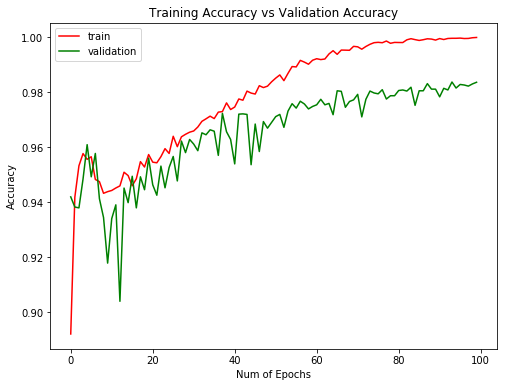

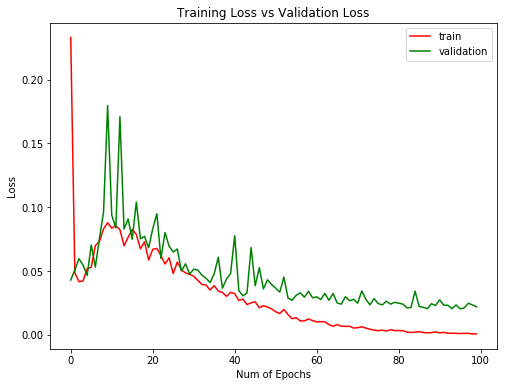

In [13]:
plt.figure(0)
plt.plot(model.history.history['acc'],'r')
plt.plot(model.history.history['val_acc'],'g')
# plt.xticks(np.arange(0, epochs, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
 
plt.figure(1)
plt.plot(model.history.history['loss'],'r')
plt.plot(model.history.history['val_loss'],'g')
# plt.xticks(np.arange(0, epochs, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
 
plt.show()

In [14]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.021945517713251275
Test accuracy: 0.9836


In [15]:
import matplotlib.pyplot as plt

{'whiskers': [<matplotlib.lines.Line2D at 0x7f980c6a5908>,
 'caps': [<matplotlib.lines.Line2D at 0x7f980be496a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f980be55160>],
 'medians': [<matplotlib.lines.Line2D at 0x7f980be49fd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f980be49ba8>],
 'means': []}

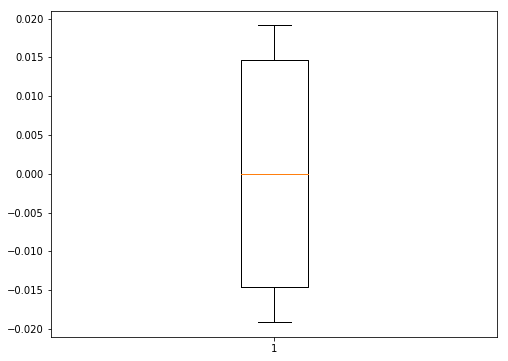

In [16]:
plt.boxplot(model.layers[4].get_weights()[0].reshape(-1))

In [21]:
result = model.predict(x=X_test)
print(np.sum(np.argmax(result, axis=1) == y_test), '/ 10000')

9836 / 10000


# Binarization of layer weigths

In [22]:
from binary_ops import xnorize # import binarization funciton

In [23]:
model.layers[0].get_weights()[0] # get one layer weigths

array([[-0.01526715,  0.00191934, -0.01407744, ..., -0.01715918,
        -0.00833443, -0.01510963],
       [ 0.00369941, -0.00755651, -0.01621231, ...,  0.01299602,
        -0.01108886, -0.01434364],
       [-0.01179592, -0.0061256 , -0.00960373, ..., -0.01212393,
        -0.01014454, -0.00343211],
       ...,
       [ 0.00452799,  0.01094631, -0.00430525, ..., -0.00982988,
        -0.00638388,  0.01059396],
       [-0.00330026, -0.00649353, -0.00343137, ...,  0.01214291,
         0.00832314, -0.0133811 ],
       [ 0.00811843,  0.00909702,  0.01573012, ...,  0.00695065,
         0.01704335, -0.00659497]], dtype=float32)

In [24]:
kerasW = K.variable(model.layers[0].get_weights()[0]) # transform ndarray in keras tensor
(Wa, Wb) = xnorize(W=kerasW)

In [25]:
K.eval(Wb) # transform Keras tensor in ndarray

array([[-1.,  1., -1., ..., -1., -1., -1.],
       [ 1., -1., -1., ...,  1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [ 1.,  1., -1., ..., -1., -1.,  1.],
       [-1., -1., -1., ...,  1.,  1., -1.],
       [ 1.,  1.,  1., ...,  1.,  1., -1.]], dtype=float32)

In [26]:
def get_binarized_params(W):
    temp_tensor = K.variable(W)
    (Wa, Wb) = xnorize(W=temp_tensor)
    return K.eval(Wb)

In [27]:
l1 = get_binarized_params(model.layers[0].get_weights()[0])
l2 = get_binarized_params(model.layers[2].get_weights()[0])
l3 = get_binarized_params(model.layers[4].get_weights()[0])

In [28]:
l1, l2, l3

(array([[-1.,  1., -1., ..., -1., -1., -1.],
        [ 1., -1., -1., ...,  1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [ 1.,  1., -1., ..., -1., -1.,  1.],
        [-1., -1., -1., ...,  1.,  1., -1.],
        [ 1.,  1.,  1., ...,  1.,  1., -1.]], dtype=float32),
 array([[-1.,  1.,  1., ..., -1.,  1., -1.],
        [ 1.,  1., -1., ...,  1., -1.,  1.],
        [-1.,  1., -1., ..., -1.,  1.,  1.],
        ...,
        [ 1., -1., -1., ..., -1., -1., -1.],
        [-1.,  1.,  1., ..., -1.,  1., -1.],
        [-1.,  1.,  1., ..., -1.,  1., -1.]], dtype=float32),
 array([[ 1., -1., -1., ...,  1.,  1., -1.],
        [ 1., -1., -1., ..., -1., -1.,  1.],
        [-1., -1., -1., ..., -1.,  1., -1.],
        ...,
        [-1.,  1., -1., ...,  1., -1.,  1.],
        [ 1., -1., -1., ...,  1.,  1., -1.],
        [ 1.,  1., -1., ..., -1.,  1.,  1.]], dtype=float32))

In [29]:
model.layers[0].set_weights(weights=[l1])
model.layers[2].set_weights(weights=[l2])
model.layers[4].set_weights(weights=[l3])

In [30]:
print(model.layers[0].get_weights()[0])
print(model.layers[2].get_weights()[0])
print(model.layers[4].get_weights()[0])

[[-1.  1. -1. ... -1. -1. -1.]
 [ 1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [ 1.  1. -1. ... -1. -1.  1.]
 [-1. -1. -1. ...  1.  1. -1.]
 [ 1.  1.  1. ...  1.  1. -1.]]
[[-1.  1.  1. ... -1.  1. -1.]
 [ 1.  1. -1. ...  1. -1.  1.]
 [-1.  1. -1. ... -1.  1.  1.]
 ...
 [ 1. -1. -1. ... -1. -1. -1.]
 [-1.  1.  1. ... -1.  1. -1.]
 [-1.  1.  1. ... -1.  1. -1.]]
[[ 1. -1. -1. ...  1.  1. -1.]
 [ 1. -1. -1. ... -1. -1.  1.]
 [-1. -1. -1. ... -1.  1. -1.]
 ...
 [-1.  1. -1. ...  1. -1.  1.]
 [ 1. -1. -1. ...  1.  1. -1.]
 [ 1.  1. -1. ... -1.  1.  1.]]


In [31]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9834


{'whiskers': [<matplotlib.lines.Line2D at 0x7f980ba0aa58>,
 'caps': [<matplotlib.lines.Line2D at 0x7f980ba14358>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f980ba0a908>],
 'medians': [<matplotlib.lines.Line2D at 0x7f980ba14ba8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f980ba14fd0>],
 'means': []}

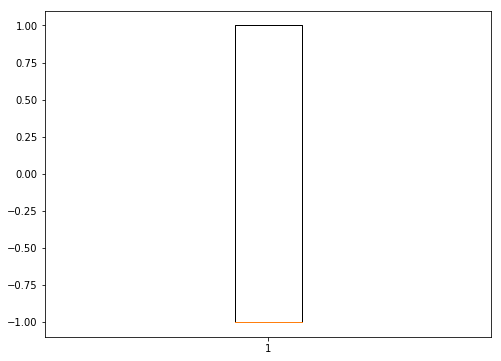

In [33]:
plt.boxplot(model.layers[4].get_weights()[0].reshape(-1))

# Binarized input

In [34]:
X_test_bin = get_binarized_params(X_test)
print(X_test_bin)

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


In [35]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9834


# Acks

This notebook uses code from and inspired by [2] for the binarized layers implementation.

[1] https://github.com/mjiansun/cifar10-vgg16/blob/master/vgg_transfer.py [2] https://github.com/DingKe/BinaryNet